## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic

### Data Loading and Cleaning

In [ ]:
# start_month: 1-12
def download_data(start_year, start_month=1, path = 'Data'):
  start_month = start_month - 1

  months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
  start_year = 2017 if start_year < 2017 else start_year # limiting to 2017 because they had different data structures before that
  end_year = 2023
  end_month = 3
  data_frames = []

  for i in range(12 * (end_year - start_year) + end_month - start_month):
    month = months[(i + start_month) % 12]
    year = int(start_year + (i + start_month) / 12)
    
    #Use below for google colab
    '''
    !echo http://s3.amazonaws.com/tripdata/$year$month-citibike-tripdata.csv.zip
    !wget -q http://s3.amazonaws.com/tripdata/$year$month-citibike-tripdata.csv.zip
    !unzip -o $year$month-citibike-tripdata.csv.zip
    # for some reason these downloads fail, we can upload the data manually
    if not (year == 2022 and month == "06") and not (year == 2022 and month == "07"):
      data_frames.append(pd.read_csv("{}{}-citibike-tripdata.csv".format(year, month)))
    '''
    #Use below for not google colab (must download and extract csv files into folder specified by path parameter)
    data_frames.append(pd.read_csv(path + "\{}{}-citibike-tripdata.csv".format(year, month)))
  
  final_df = pd.concat(data_frames, axis=0, ignore_index=True)
  data_frames = []
  final_df.dropna(inplace=True) # drop NaN
  final_df = final_df.sort_values(by="started_at") # sort by start time

  return final_df

data = download_data(2023, 3)
data.head() # we will split train/test data later

In [3]:
len(data)

2188420

### Data Preprocessing- Mundane Stuff


In [4]:
data['start_station_id'].values

array([4395.07, 5721.14, 5886.13, ..., 7511.19, 7372.1 , 6280.12])

In [5]:

#This code does not take into account if there are some end stations that are not in start stations
# Reassign the station id to a standard #
locations = data['start_station_id'].unique()
new_ids = list(range(len(data['start_station_id'].unique())))
mapping = dict(zip(locations, new_ids))

data['start_station_id'] = data['start_station_id'].map(mapping)
data['end_station_id'] = data['end_station_id'].map(mapping)

'''
#Reassigns station id to a standard #, taking to account if there are some end stations not in start stations and vice verso
all_location_ids = np.concatenate((data['start_station_id'].values, data['end_station_id']), axis=0).astype(str)
all_location_ids = np.unique(all_location_ids)
new_ids = list(range(len(all_location_ids)))
mapping = dict(zip(all_location_ids, new_ids))

data['start_station_id'] = data['start_station_id'].astype(str).map(mapping)
data['end_station_id'] = data['end_station_id'].astype(str).map(mapping)
'''

"\n#Reassigns station id to a standard #, taking to account if there are some end stations not in start stations and vice verso\nall_location_ids = np.concatenate((data['start_station_id'].values, data['end_station_id']), axis=0).astype(str)\nall_location_ids = np.unique(all_location_ids)\nnew_ids = list(range(len(all_location_ids)))\nmapping = dict(zip(all_location_ids, new_ids))\n\ndata['start_station_id'] = data['start_station_id'].astype(str).map(mapping)\ndata['end_station_id'] = data['end_station_id'].astype(str).map(mapping)\n"

In [6]:
data[data.isna().any(axis=1)]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
704451,ECE8DD5F42A4DC7B,classic_bike,2023-03-01 00:00:03,2023-03-01 00:05:14,Hanson Pl & Ashland Pl,0,Carroll St & 6 Ave,NaN,40.685010,-73.977699,40.674089,-73.978728,member
1696235,C36627A7EF6F32DB,electric_bike,2023-03-01 00:00:18,2023-03-01 00:33:16,LaGuardia Pl & W 3 St,1,LaGuardia Pl & W 3 St,NaN,40.729170,-73.998102,40.729170,-73.998102,member
1021853,EDCE1C1D0408C24E,classic_bike,2023-03-01 00:00:28,2023-03-01 00:15:16,W 47 St & 10 Ave,3,Sullivan St & Washington Sq,NaN,40.762726,-73.993001,40.730477,-73.999061,member
2141632,7DB86DAEE8F1C40B,classic_bike,2023-03-01 00:00:29,2023-03-01 00:05:54,1 Ave & E 110 St,4,Central Park North & Adam Clayton Powell Blvd,NaN,40.792351,-73.938264,40.799484,-73.955613,member
1815421,1620FCEB52A21A8C,classic_bike,2023-03-01 00:00:32,2023-03-01 00:06:19,Henry St & Grand St,6,E 7 St & Ave C,NaN,40.714217,-73.981083,40.724129,-73.979013,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180362,A65ABEEAFB542926,classic_bike,2023-03-31 23:59:42,2023-04-01 00:10:21,Columbus Ave & W 72 St,505,E 59 St & Madison Ave,NaN,40.776825,-73.979105,40.763505,-73.971092,casual
1729668,AF0557D4983E903B,classic_bike,2023-03-31 23:59:55,2023-04-01 00:04:35,W 148 St & Amsterdam Ave,1641,Broadway & W 168 St,NaN,40.827032,-73.945940,40.840896,-73.939721,member
616392,392DDBFC030D0C35,classic_bike,2023-03-31 23:59:56,2023-04-01 00:06:54,40 Ave & 9 St,42,31 St & Newtown Ave,NaN,40.757493,-73.945356,40.767549,-73.920933,member
1543363,5A0119844DD3B675,classic_bike,2023-03-31 23:59:57,2023-04-01 00:17:36,5 Ave & E 93 St,548,40 Ave & 9 St,NaN,40.785943,-73.957477,40.757420,-73.945133,member


In [7]:
data = data.dropna()

In [8]:
data[data.isna().any(axis=1)]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual


In [9]:
# convert strings into date objects
data["started_at"] = pd.to_datetime(data["started_at"], format="%Y-%m-%d %H:%M:%S")
data["ended_at"] = pd.to_datetime(data["ended_at"], format="%Y-%m-%d %H:%M:%S")

# calculate strip duration in seconds
data['trip_duration'] = (data['ended_at'] - data['started_at']).dt.total_seconds()

data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration
1430211,837ECA56CB7EC87B,classic_bike,2023-03-01 00:00:22,2023-03-01 00:05:15,E 20 St & FDR Dr,2,University Pl & E 14 St,87.0,40.733272,-73.975632,40.734814,-73.992085,member,293.0
1067453,608DA83170DF68BB,classic_bike,2023-03-01 00:00:31,2023-03-01 00:21:21,E 33 St & 1 Ave,5,South St & Whitehall St,701.0,40.743553,-73.975172,40.701221,-74.012342,member,1250.0
495152,E288F7A86C3EEE2E,classic_bike,2023-03-01 00:01:02,2023-03-01 00:07:13,Kenmare St & Elizabeth St,15,Pike St & E Broadway,139.0,40.720691,-73.994833,40.714067,-73.992939,member,371.0
807832,1E7B0092BF86C8E9,classic_bike,2023-03-01 00:01:27,2023-03-01 00:04:15,Pacific St & Troy Ave,16,Bergen St & Kingston Ave,1015.0,40.676860,-73.936070,40.675600,-73.941500,member,168.0
1393964,C10170585EFC4497,classic_bike,2023-03-01 00:01:29,2023-03-01 00:48:54,W 20 St & 5 Ave,7,Broadway & W 48 St,343.0,40.739730,-73.991040,40.760177,-73.984868,casual,2845.0


### Nodes


In [10]:
outgoing_trips = data.groupby("start_station_id").count()
incoming_trips = data.groupby("end_station_id").count()

In [11]:
print(incoming_trips.index[0:100])

Float64Index([  7.0,  17.0,  18.0,  24.0,  27.0,  35.0,  36.0,  39.0,  43.0,
               44.0,  47.0,  51.0,  52.0,  53.0,  54.0,  55.0,  56.0,  61.0,
               64.0,  72.0,  76.0,  77.0,  85.0,  86.0,  87.0,  89.0,  96.0,
              101.0, 106.0, 114.0, 115.0, 116.0, 121.0, 124.0, 126.0, 128.0,
              129.0, 130.0, 131.0, 132.0, 133.0, 137.0, 139.0, 141.0, 142.0,
              147.0, 149.0, 156.0, 159.0, 165.0, 169.0, 173.0, 180.0, 181.0,
              183.0, 187.0, 191.0, 192.0, 194.0, 197.0, 200.0, 204.0, 208.0,
              214.0, 219.0, 221.0, 231.0, 236.0, 239.0, 243.0, 251.0, 256.0,
              258.0, 263.0, 265.0, 268.0, 269.0, 270.0, 272.0, 273.0, 274.0,
              276.0, 278.0, 279.0, 282.0, 285.0, 287.0, 288.0, 292.0, 298.0,
              299.0, 301.0, 302.0, 310.0, 311.0, 313.0, 314.0, 318.0, 325.0,
              335.0],
             dtype='float64', name='end_station_id')


In [12]:
print(data.groupby("start_station_id").count())

                  ride_id  rideable_type  started_at  ended_at  \
start_station_id                                                 
0                     532            532         532       532   
1                     667            667         667       667   
2                    1035           1035        1035      1035   
3                     925            925         925       925   
4                     205            205         205       205   
...                   ...            ...         ...       ...   
1803                   46             46          46        46   
1804                    3              3           3         3   
1805                    2              2           2         2   
1806                    1              1           1         1   
1807                    6              6           6         6   

                  start_station_name  end_station_name  end_station_id  \
start_station_id                                                   

In [13]:
import numpy as np
# Find out how many outgoing bikers we have
outgoing_trips = data.groupby("start_station_id").count()
incoming_trips = data.groupby("end_station_id").count()

# Match the list sizes
actual_incoming_trips = []
for idx in outgoing_trips.index:
  if idx not in incoming_trips.index:
    actual_incoming_trips.append(0)
  else:
    actual_incoming_trips.append(incoming_trips.loc[[idx]]['ride_id'].values[0])

actual_incoming_trips = np.asarray(actual_incoming_trips)
incoming_trips = actual_incoming_trips
outgoing_trips = outgoing_trips['ride_id'].values

# Normalize features between 0 and 1
outgoing_trips = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

node_features = np.stack([outgoing_trips, incoming_trips]).transpose()
print("Full shape: ", node_features.shape)
node_features[0:5]

Full shape:  (1808, 2)


array([[0.18424705, 0.        ],
       [0.23108952, 0.        ],
       [0.35877863, 0.        ],
       [0.32061069, 0.        ],
       [0.07078418, 0.        ]])

### Edges


In [14]:
cols = ["start_lng", "start_lat", "end_lng", "end_lat", "start_station_id", "end_station_id"]
#station_pairs = data.drop_duplicates(subset=["start_station_id", "end_station_id" ], keep="first")[cols]
#station_pairs["distance"] = station_pairs.apply(lambda x: geodesic((x["start_lat"], x["start_lng"]), (x["end_lat"], x["end_lng"])).meters, axis=1)
#station_pairs.to_csv("Data\station_pairs2023-3only.csv")
station_pairs = pd.read_csv("Data\station_pairs2023-3only.csv")


In [15]:
station_pairs["edge"] = station_pairs["distance"] < 150 # we will only consider edges less than 300 meters to limit the complexity of the model
station_pairs

,Unnamed: 0,start_lng,start_lat,end_lng,end_lat,start_station_id,end_station_id,distance,edge
0,1430211,-73.975632,40.733272,-73.992085,40.734814,2,87.0,1400.334392,False
1,1067453,-73.975172,40.743553,-74.012342,40.701221,5,701.0,5653.336216,False
2,495152,-73.994833,40.720691,-73.992939,40.714067,15,139.0,752.817038,False
3,807832,-73.936070,40.676860,-73.941500,40.675600,16,1015.0,479.931426,False
4,1393964,-73.991040,40.739730,-73.984868,40.760177,7,343.0,2329.729853,False
...,...,...,...,...,...,...,...,...,...
92792,480158,-74.008444,40.719985,-73.977688,40.725213,1076,130.0,2662.592263,False
92793,353214,-73.981909,40.693534,-73.971763,40.679119,769,1342.0,1816.099905,False
92794,256109,-73.982090,40.670484,-73.944470,40.674120,1284,1327.0,3206.293487,False
92795,851457,-73.917152,40.754959,-73.959607,40.743366,993,510.0,3809.607371,False


In [16]:
edge_index = station_pairs[station_pairs["edge"] == True][["start_station_id", "end_station_id"]].values
edge_index = edge_index.transpose()
print(edge_index.size)
edge_index

1370


array([[  51.,  132.,  108., ..., 1805., 1802., 1802.],
       [  51.,  132.,  219., ..., 1805., 1802., 1799.]])

In [17]:
print(np.shape(edge_index))
print(np.min(edge_index))
print(np.max(edge_index))

(2, 685)
7.0
1805.0


In [18]:
len(edge_index.T[np.isnan(edge_index.T).any(axis=1)])

0

In [19]:
edge_features = station_pairs[station_pairs["edge"] == True]["distance"].values
#edge_features

In [20]:
from pandas._libs.tslibs.offsets import YearOffset
start_date = data.iloc[0]['started_at']
end_date = data.iloc[-1]['started_at']
interval = timedelta(hours=3)


labels = []

#stop = start_date + timedelta(hours=24)
#while start_date <= stop:
while start_date <= end_date:
    
    current_snapshot = data[((start_date + interval) >= data["ended_at"]) & (start_date <= data["ended_at"])]
    
    # Compute average duration of trips along the same edge
    current_snapshot = current_snapshot.groupby(["start_station_id", "end_station_id"]).mean().reset_index()
    
    # Labels as the number of outgoing trips from each station within this hour
    start_stations = np.zeros_like(data["start_station_id"].unique())

    y = current_snapshot.groupby("start_station_id").count()['start_lat'].values
    y_index = np.unique(current_snapshot[["start_station_id"]].values.transpose())

    
    start_stations[y_index] = y
    labels.append(start_stations)

    start_date += interval


In [21]:
print(len(labels))
i = 9
print(f"""Example of graph snapshot {i}: \n
      Node feature shape: {node_features.shape} \n
      Edge index shape: {edge_index.shape} \n
      Edge feature shape: {edge_features.shape} \n 
      Labels shape: {labels[i].shape} \n
      """)

248
Example of graph snapshot 9: 

      Node feature shape: (1808, 2) 

      Edge index shape: (2, 685) 

      Edge feature shape: (685,) 
 
      Labels shape: (1808,) 

      


In [22]:
labels[9][100:200]

array([0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0], dtype=int64)

### Sliding Window to Map Labels (Features) to Labels (Targets)

In [23]:
outgoing = np.array(labels)

outgoing[i][j] is an array that contains the number of outgoing trips from the jth station in the ith timestep

outgoing is our feature and our target, if we use 5 timesteps to predict the next 5 steps, then 
outgoing[i-5:i][:] would be our x, and outgoing[i:i + 5][:] would be our y.
We use a sliding window to construct our x and y from outgoing


In [24]:
np.shape(outgoing)

(248, 1808)

In [25]:
np.shape(np.sum(outgoing, axis=1))

(248,)

<AxesSubplot:xlabel='index', ylabel='trips_per_hour'>

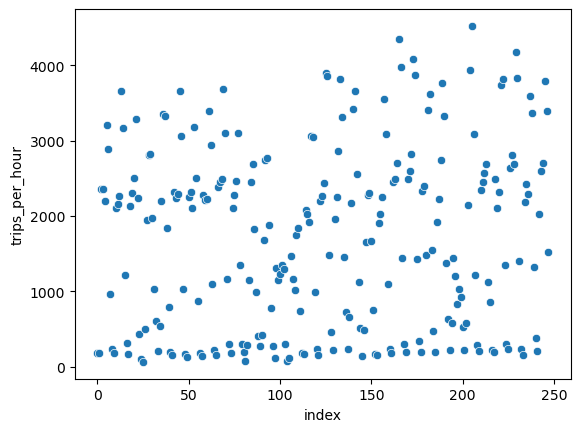

In [26]:
import seaborn as sns
sns.scatterplot(x="index", y="trips_per_hour", data=pd.DataFrame(np.sum(outgoing, axis = 1), columns=["trips_per_hour"]).reset_index())

(array([65., 16., 27., 16., 37., 36., 18., 14., 15.,  4.]),
 array([  63. ,  508.7,  954.4, 1400.1, 1845.8, 2291.5, 2737.2, 3182.9,
        3628.6, 4074.3, 4520. ]),
 <BarContainer object of 10 artists>)

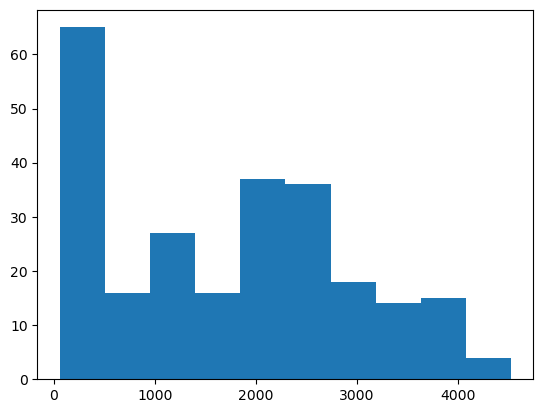

In [27]:
import matplotlib.pyplot as plt
plt.hist(np.sum(outgoing, axis = 1))

(array([65., 16., 27., 16., 37., 36., 18., 14., 15.,  4.]),
 array([0.03484513, 0.28136062, 0.52787611, 0.77439159, 1.02090708,
        1.26742257, 1.51393805, 1.76045354, 2.00696903, 2.25348451,
        2.5       ]),
 <BarContainer object of 10 artists>)

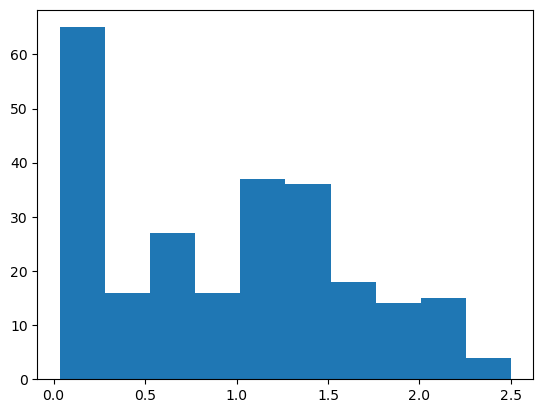

In [28]:
plt.hist(np.average(outgoing, axis=1))

In [29]:
np.max(edge_index)

1805.0

In [30]:
from typing import Tuple
import math
#need to create features np array and targets np array
#using sliding window
#parameters time_steps_in and time_steps_out
#should use 24 hours for proof of concept
def sliding_window(data: np.array, timestep_in: int, timestep_out: int, overlap = True) -> Tuple[np.array, np.array]:
    if(overlap):
        n = len(data)
        if(timestep_in + timestep_out > len(data)):
            print("Timestep sizes (" + str(timestep_in) + ", " + str(timestep_out) + ") are too large for data length: " + str(n))
        else:
            x = np.array([data[i: i + timestep_in] for i in range(n - timestep_in - timestep_out + 1)])
            y = np.array([data[i: i + timestep_out] for i in range(timestep_in, n - timestep_out + 1)])
            return(x, y)
    else:
        n = len(data)
        if(timestep_in + timestep_out > len(data)):
            print("Timestep sizes (" + str(timestep_in) + ", " + str(timestep_out) + ") are too large for data length: " + str(n))
        else:
            total = np.array([data[i: i + timestep_in + timestep_out] for i in range(0, n - timestep_in + 1, timestep_out + timestep_in)])
            x = np.array([arr[0:timestep_in] for arr in total])
            y = np.array([arr[timestep_in:] for arr in total])
            return(x, y)

x, y = sliding_window(np.arange(24), 4, 2, False)
print(len(x) == len(y))
for i in range(len(x)):
    print(str(x[i]) + "  :      " + str(y[i]))

True
[0 1 2 3]  :      [4 5]
[6 7 8 9]  :      [10 11]
[12 13 14 15]  :      [16 17]
[18 19 20 21]  :      [22 23]


In [31]:
x, y = sliding_window(outgoing, 12, 1, False)
#reshaping x and y for temporal graph neural network
x = np.expand_dims(np.transpose(x, (0, 2, 1)), axis = 2)
y = np.transpose(y, (0, 2, 1))
print("Shape of x: " + str(np.shape(x)))
print("Shape of y: " + str(np.shape(y)))

Shape of x: (19, 1808, 1, 12)
Shape of y: (19, 1808, 1)


## Creating Basic Graph Neural Network

### Creating Graph Objects

#### Creating First Graph Object

In [32]:
import torch
import torch_geometric
import torch_geometric_temporal
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric_temporal import StaticGraphTemporalSignal

In [33]:
temporal_dataset = StaticGraphTemporalSignal(edge_index=edge_index, edge_weight=edge_features, features=x, targets=y)

In [34]:
print(temporal_dataset[0])

Data(x=[1808, 1, 12], edge_index=[2, 685], edge_attr=[685], y=[1808, 1])


In [35]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(temporal_dataset, train_ratio=0.8)

#print("Number of train buckets: ", len(set(train_dataset)))
#print("Number of test buckets: ", len(set(test_dataset)))

In [36]:
type(train_dataset)

torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal

In [37]:
train_dataset.snapshot_count

15

In [38]:
next(iter(train_dataset))

Data(x=[1808, 1, 12], edge_index=[2, 685], edge_attr=[685], y=[1808, 1])

In [39]:
np.shape(x)

(19, 1808, 1, 12)

In [40]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

#used https://www.youtube.com/watch?v=Rws9mf1aWUs to help with temporal GNN syntax and implementation

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods_in, periods_out):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods_in)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods_out)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=1, periods_in=12, periods_out = 1)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(1, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(1, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [44]:
#used https://www.youtube.com/watch?v=Rws9mf1aWUs to help with temporal GNN syntax and implementation

# GPU support
device = torch.device('cpu') # cuda
subset = 100 #can modify subset when running into memory bottlenecks

# Create model and optimizers
model = TemporalGNN(node_features=1, periods_in=12, periods_out=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

training_mses = []
testing_mses = []

print("Running training...")
for epoch in range(100): 
    loss = 0
    step = 0
    snapshot_count = train_dataset.snapshot_count
    if(snapshot_count > subset):
      skip = 0
      for snapshot in train_dataset:
        if skip < snapshot_count - subset:
          skip += 1
        else:
          #print(step)
          snapshot = snapshot.to(device)
          # Get model predictions
          y_hat = model(snapshot.x, snapshot.edge_index)
          # Mean squared error
          loss = loss + torch.mean((y_hat-snapshot.y)**2) 
          step += 1
    else:
      for snapshot in train_dataset:
          #print(step)
          snapshot = snapshot.to(device)
          # Get model predictions
          y_hat = model(snapshot.x, snapshot.edge_index)
          # Mean squared error
          loss = loss + torch.mean((y_hat-snapshot.y)**2) 
          step += 1
          if step > subset:
            break

    loss = loss / (step + 1)
    training_mses.append(loss.item())
    model.eval()
    with torch.no_grad():
      testing_loss = 0
      testing_step = 0
      for snapshot in test_dataset:
        y_hat = model(snapshot.x, snapshot.edge_index)
        testing_loss = testing_loss + torch.mean((y_hat-snapshot.y)**2)
        testing_step += 1
      testing_loss = testing_loss / (testing_step + 1)
      testing_mses.append(testing_loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))
    print("Epoch {} test MSE: {:.4f}".format(epoch, testing_loss.item()))

Running training...
Epoch 0 train MSE: 3.4430
Epoch 0 test MSE: 3.7047
Epoch 1 train MSE: 3.2467
Epoch 1 test MSE: 3.4935
Epoch 2 train MSE: 3.0767
Epoch 2 test MSE: 3.3099
Epoch 3 train MSE: 2.9151
Epoch 3 test MSE: 3.1335
Epoch 4 train MSE: 2.7501
Epoch 4 test MSE: 2.9517
Epoch 5 train MSE: 2.5896
Epoch 5 test MSE: 2.7726
Epoch 6 train MSE: 2.4380
Epoch 6 test MSE: 2.6004
Epoch 7 train MSE: 2.3005
Epoch 7 test MSE: 2.4398
Epoch 8 train MSE: 2.1817
Epoch 8 test MSE: 2.2953
Epoch 9 train MSE: 2.0875
Epoch 9 test MSE: 2.1724
Epoch 10 train MSE: 2.0254
Epoch 10 test MSE: 2.0787
Epoch 11 train MSE: 1.9982
Epoch 11 test MSE: 2.0185
Epoch 12 train MSE: 1.9984
Epoch 12 test MSE: 1.9872
Epoch 13 train MSE: 2.0108
Epoch 13 test MSE: 1.9731
Epoch 14 train MSE: 2.0212
Epoch 14 test MSE: 1.9643
Epoch 15 train MSE: 2.0208
Epoch 15 test MSE: 1.9525
Epoch 16 train MSE: 2.0063
Epoch 16 test MSE: 1.9342
Epoch 17 train MSE: 1.9792
Epoch 17 test MSE: 1.9095
Epoch 18 train MSE: 1.9438
Epoch 18 test MSE: 

<AxesSubplot:title={'center':'Training and Testing Loss'}, xlabel='Epoch', ylabel='Mean Squared Error'>

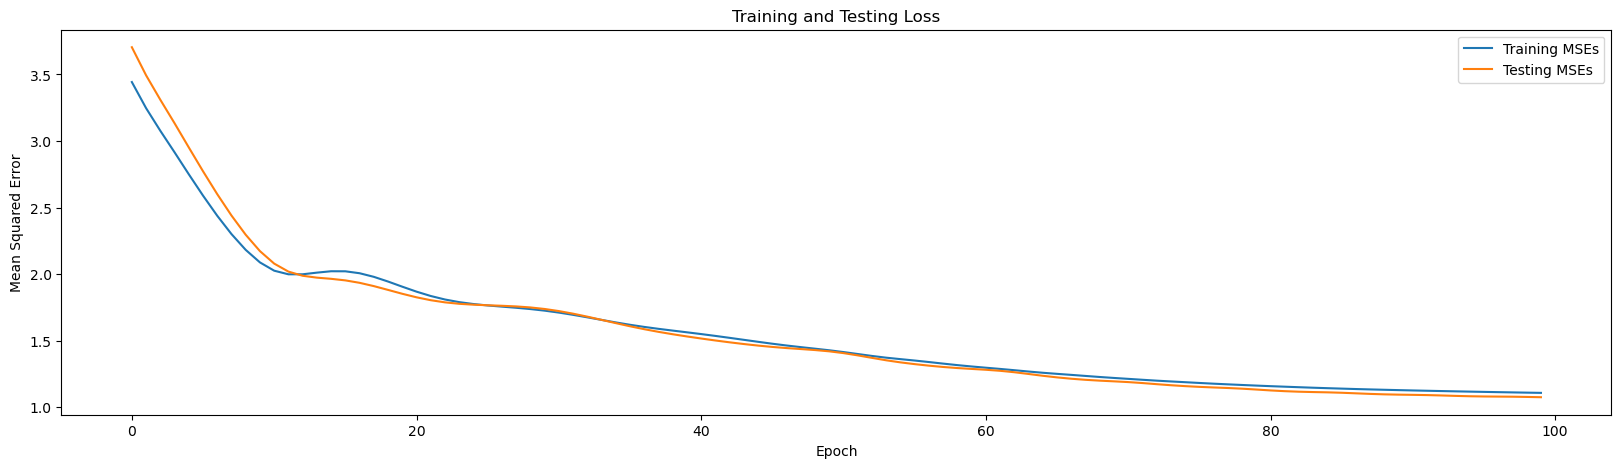

In [45]:
plt.figure(figsize=(20,5))
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Training and Testing Loss")

sns.lineplot(data=training_mses, label="Training MSEs")
sns.lineplot(data=testing_mses, label="Testing MSEs")

In [46]:
loss_tuples = list(zip(training_mses, testing_mses))
loss_df = pd.DataFrame(loss_tuples, columns=["Training MSE", "Testing MSE"])
loss_df.to_csv("Data/losses_most_recent_best_3_12_1.csv")

In [47]:
model.eval()
loss = 0
step = 0
horizon = 12

# Store for analysis
predictions = []
actuals = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    actuals.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    #if step > horizon:
    #      break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 1.0729


In [ ]:
np.shape(outgoing[0])

(1808,)

Data points:, (4,)


<AxesSubplot:>

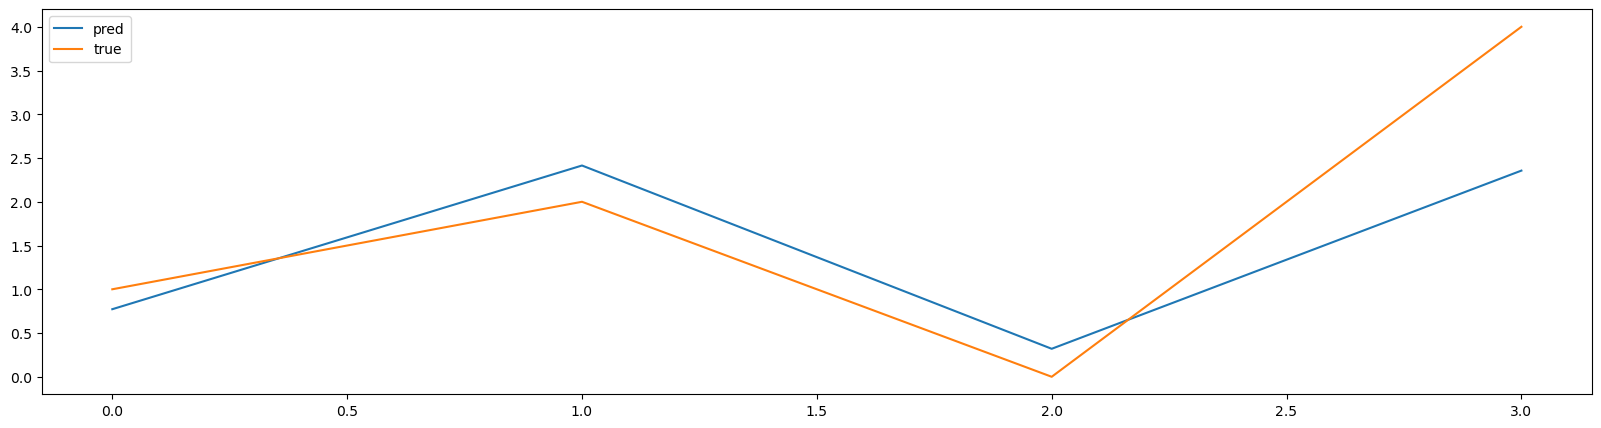

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
biggest_sensor = np.argmax(np.sum(outgoing, axis = 1))
sensor = biggest_sensor
timestep = 0
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in actuals])
print("Data points:,", preds.shape)

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")